In [1]:
# LDA analysis Done

In [2]:
import glob
from datetime import datetime
import logging as log
import gensim
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from sklearn.externals import joblib
import gzip
from multiprocessing import Pool
import time
import numpy as np


import pandas as pd
from collections import OrderedDict
from datetime import date
from IPython.display import display, HTML
log.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=log.INFO)

import matplotlib
matplotlib.style.use('ggplot')
%matplotlib notebook

In [3]:
class ModelSimilarity:

    # Uses a model (e.g. Word2Vec model) to calculate the similarity between two terms.
    
    def __init__(self, model):
        self.model = model

    def similarity(self, ranking_i, ranking_j):
        sim = 0.0
        pairs = 0
        for term_i in ranking_i:
            for term_j in ranking_j:
                try:
                    sim += self.model.similarity(term_i, term_j)
                    pairs += 1
                except:
                    # print "Failed pair (%s,%s)" % (term_i,term_j)
                    pass
        if pairs == 0:
            return 0.0
        return sim / pairs

In [4]:
class WithinTopicMeasure:
 
    # Measures within-topic coherence for a topic model, based on a set of term rankings.

    def __init__(self, metric):
        self.metric = metric

    def evaluate_ranking(self, term_ranking):
        return self.metric.similarity(term_ranking, term_ranking)

    def evaluate_rankings(self, term_rankings):
        scores = []
        overall = 0.0
        for topic_index in range(len(term_rankings)):
            score = self.evaluate_ranking(term_rankings[topic_index])
            scores.append(score)
            overall += score
        overall /= len(term_rankings)
        return overall

In [5]:
# To get the topic words from the model
def get_topics(ldamodel, num_topics, num_words):    
    top_words = [[word for word, _ in ldamodel.show_topic(topicno, topn=num_words)] 
                 for topicno in range(ldamodel.num_topics)]
#     print(top_words)
    return top_words


In [6]:
class MyDocuments(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        with gzip.open(self.dirname, 'rb') as f:
            for line in f:
                yield line.decode().split('\t')[1].split()

In [7]:
def execute_coherence(topic_model_path):
    
    
    model_list = glob.glob(topic_model_path)
    model_list.sort()

    model_path = 'data/eos/word2vec_model_all.model'
    log.info("Loading Word2Vec model from %s ..." % model_path)
    model = gensim.models.Word2Vec.load(model_path)
    
    metric = ModelSimilarity(model)
    validation_measure = WithinTopicMeasure(metric)

    indices =[]
    for fname in model_list:
        window = fname[-16:-9]
        indices.append(window)
        
    indices = list(set(indices))
    indices.sort()
#     print(indices)
    
    coherence_list = {}
    for window in indices:
        start_time = time.time()
        temp = []
        for fname in model_list:
            if (window == fname[-16:-9]):
                ldamodel = joblib.load(fname)
                topic_num = int(fname[-6:-4])
                truncated_term_rankings = get_topics(ldamodel, topic_num, 20)
                coherence_score = validation_measure.evaluate_rankings(truncated_term_rankings)
                log.info("Model coherence window=%s (k=%d) = %.4f" % (window, topic_num, coherence_score))
                temp.append ([topic_num, coherence_score])
        coherence_list[window] = temp
        
        elapsed_time = time.time() - start_time
        print('took %s to process %s' % (elapsed_time, topic_model_path) )
    

    return coherence_list, indices    

In [8]:
def execute_coherence_gensim(topic_model_path):
    
    dictionary_filepath = 'data/eos/dic_bow/bigram_dict_%s.dict' 
    bow_filepath = 'data/eos/dic_bow/bigram_bow_corpus_%s.mm'    
    
    model_list = glob.glob(topic_model_path)
    model_list.sort()

    indices =[]
    for fname in model_list:
        window = fname[-16:-9]
        indices.append(window)
        
    indices = list(set(indices))
    indices.sort()
    print(indices)
    
    coherence_list = {}
    for window in indices:
        temp = []
        # Load to memory
        corpus = gensim.corpora.MmCorpus(bow_filepath % window)
        dictionary = gensim.corpora.Dictionary.load(dictionary_filepath % window)    
        corpus_text = MyDocuments('dynamic_nmf/data/windowbin/slices/tokenized_window_%s.gz' % window)   
        for fname in model_list:
            if (window == fname[-16:-9]):
                ldamodel = joblib.load(fname)
                topic_num = int(fname[-6:-4])
                cm = CoherenceModel(dictionary=dictionary, corpus=corpus, 
                                    texts=corpus_text, topics=get_topics(ldamodel, topic_num, 20), 
                                    coherence='c_v')
                #     print(cm)
                coherence_score = cm.get_coherence()                
                log.info("Model coherence window=%s (k=%d) = %.4f" % (window, topic_num, coherence_score))
                temp.append ([topic_num, coherence_score])
        coherence_list[window] = temp

        
    return coherence_list, indices

In [24]:

model_list = {
              'lda' : 'data/eos/lda/LDAmodel_*.pkl', 
              'lsi' : 'data/eos/lsi/LSImodel_*.pkl', 
              'mallet' : 'data/eos/mallet/Malletmodel_*.pkl'
             }


In [10]:
def sort_coherence(coherence_dict):
    
    y_coherence = []
    y_k = []
    
    for key in sorted(coherence_dict):
        coherence_dict[key].sort(key=lambda x: x[1], reverse=True)
#         print ("%s : %s" % (key, coherence_dict[key]))
        y_k.append(coherence_dict[key][0][0])
        y_coherence.append(coherence_dict[key][0][1])

#     print(y_coherence)
#     print(y_k)
    return y_coherence, y_k

In [11]:
%%time



df = pd.DataFrame()
# Run TC-W2V coherense score
for name, path in model_list.items():
    print (name, path) 
    coherence_list, indices = execute_coherence(path)
    y_coherence, y_k = sort_coherence(coherence_list)
    df['window'] = indices
    df['%s_TC_W2V' % name] = y_coherence
    df['%s_TC_W2V_k' % name] = y_k
    

df.set_index(df['window'], inplace=True)
display(df.head())
df.to_csv('dynamic_nmf/data/windowbin/csv/windows_coherence_k_performance.csv')



mallet data/eos/mallet/Malletmodel_*.pkl
took 244.52745938301086 to process data/eos/mallet/Malletmodel_*.pkl
lda data/eos/lda/LDAmodel_*.pkl
took 294.26973938941956 to process data/eos/lda/LDAmodel_*.pkl
lsi data/eos/lsi/LSImodel_*.pkl
took 251.3368363380432 to process data/eos/lsi/LSImodel_*.pkl


,window,mallet_TC_W2V,mallet_TC_W2V_k,lda_TC_W2V,lda_TC_W2V_k,lsi_TC_W2V,lsi_TC_W2V_k
window,,,,,,,
2012_01,2012_01,0.373322,22,0.367360,12,0.344060,18
2012_02,2012_02,0.371982,26,0.356412,14,0.356953,12
2012_03,2012_03,0.376637,28,0.358276,20,0.354839,10
2012_04,2012_04,0.372540,24,0.356079,10,0.344663,16
2012_05,2012_05,0.385459,16,0.369615,10,0.385599,10


CPU times: user 11min 24s, sys: 6.37 s, total: 11min 30s
Wall time: 13min 11s


In [25]:
%%time


df = pd.read_csv('dynamic_nmf/data/windowbin/csv/windows_coherence_k_performance.csv')
display(df.tail())

# Run Gensim on LDA/LSA/Mallet
for name, path in model_list.items() :
    print (name, path)    
    coherence_list, indices = execute_coherence_gensim(path)
    y_coherence, y_k = sort_coherence(coherence_list)
    df['%s_Unify' % name] = y_coherence
    df['%s_Unify_k' % name] = y_k
    

display(df.head())
display(df.tail())
df.to_csv('dynamic_nmf/data/windowbin/csv/windows_coherence_k_performance.csv')



,Unnamed: 0,window,window.1,mallet_TC_W2V,mallet_TC_W2V_k,lda_TC_W2V,lda_TC_W2V_k,lsi_TC_W2V,lsi_TC_W2V_k,NMF_TC_W2V,NMF_TC_W2V_k,NMF_Unify,NMF_Unify_k
62,62,2017_03,2017_03,0.368832,22,0.344859,28,0.336967,24,0.375299,28,0.690587,22
63,63,2017_04,2017_04,0.366006,12,0.341303,20,0.326046,12,0.374008,24,0.650894,20
64,64,2017_05,2017_05,0.360582,22,0.333149,28,0.319035,12,0.357726,30,0.677018,14
65,65,2017_06,2017_06,0.381813,28,0.335946,12,0.328623,22,0.373138,18,0.725945,10
66,66,2017_07,2017_07,0.349201,22,0.339650,28,0.322636,30,0.347636,22,0.694142,16


mallet data/eos/mallet/Malletmodel_*.pkl
['2012_01', '2012_02', '2012_03', '2012_04', '2012_05', '2012_06', '2012_07', '2012_08', '2012_09', '2012_10', '2012_11', '2012_12', '2013_01', '2013_02', '2013_03', '2013_04', '2013_05', '2013_06', '2013_07', '2013_08', '2013_09', '2013_10', '2013_11', '2013_12', '2014_01', '2014_02', '2014_03', '2014_04', '2014_05', '2014_06', '2014_07', '2014_08', '2014_09', '2014_10', '2014_11', '2014_12', '2015_01', '2015_02', '2015_03', '2015_04', '2015_05', '2015_06', '2015_07', '2015_08', '2015_09', '2015_10', '2015_11', '2015_12', '2016_01', '2016_02', '2016_03', '2016_04', '2016_05', '2016_06', '2016_07', '2016_08', '2016_09', '2016_10', '2016_11', '2016_12', '2017_01', '2017_02', '2017_03', '2017_04', '2017_05', '2017_06', '2017_07']
lda data/eos/lda/LDAmodel_*.pkl
['2012_01', '2012_02', '2012_03', '2012_04', '2012_05', '2012_06', '2012_07', '2012_08', '2012_09', '2012_10', '2012_11', '2012_12', '2013_01', '2013_02', '2013_03', '2013_04', '2013_05', '

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Unnamed: 0,window,window.1,mallet_TC_W2V,mallet_TC_W2V_k,lda_TC_W2V,lda_TC_W2V_k,lsi_TC_W2V,lsi_TC_W2V_k,NMF_TC_W2V,NMF_TC_W2V_k,NMF_Unify,NMF_Unify_k,mallet_Unify,mallet_Unify_k,lda_Unify,lda_Unify_k,lsi_Unify,lsi_Unify_k
0,0,2012_01,2012_01,0.373322,22,0.367360,12,0.344060,18,0.371245,22,0.686599,16,0.570021,14,0.371903,18,0.513629,12
1,1,2012_02,2012_02,0.371982,26,0.356412,14,0.356953,12,0.360304,24,0.658763,12,0.571140,26,0.448183,22,0.525276,10
2,2,2012_03,2012_03,0.376637,28,0.358276,20,0.354839,10,0.374951,24,0.662382,24,0.573819,14,0.350011,30,0.481642,12
3,3,2012_04,2012_04,0.372540,24,0.356079,10,0.344663,16,0.369469,26,0.627686,20,0.582972,20,0.392451,26,0.557337,12
4,4,2012_05,2012_05,0.385459,16,0.369615,10,0.385599,10,0.381602,18,0.615484,30,0.586302,16,0.356175,20,0.461101,12


,Unnamed: 0,window,window.1,mallet_TC_W2V,mallet_TC_W2V_k,lda_TC_W2V,lda_TC_W2V_k,lsi_TC_W2V,lsi_TC_W2V_k,NMF_TC_W2V,NMF_TC_W2V_k,NMF_Unify,NMF_Unify_k,mallet_Unify,mallet_Unify_k,lda_Unify,lda_Unify_k,lsi_Unify,lsi_Unify_k
62,62,2017_03,2017_03,0.368832,22,0.344859,28,0.336967,24,0.375299,28,0.690587,22,0.577780,12,0.369719,26,0.376879,18
63,63,2017_04,2017_04,0.366006,12,0.341303,20,0.326046,12,0.374008,24,0.650894,20,0.583312,20,0.468642,14,0.385933,10
64,64,2017_05,2017_05,0.360582,22,0.333149,28,0.319035,12,0.357726,30,0.677018,14,0.583450,28,0.320494,26,0.389233,10
65,65,2017_06,2017_06,0.381813,28,0.335946,12,0.328623,22,0.373138,18,0.725945,10,0.607344,12,0.301083,24,0.342559,30
66,66,2017_07,2017_07,0.349201,22,0.339650,28,0.322636,30,0.347636,22,0.694142,16,0.582325,22,0.335810,28,0.452428,26


CPU times: user 2h 17min 30s, sys: 4min 4s, total: 2h 21min 35s
Wall time: 16h 8min 9s


In [ ]:

# score_df = pd.read_csv('dynamic_nmf/data/windowbin/csv/windows_coherence_k_performance.csv')


# display(score_df.tail())
# df_nmf = pd.read_csv('dynamic_nmf/data/windowbin/csv/window_topic_coherence_results.csv') 


# # df = df.drop(df.columns[0], axis=1)

# display(df_nmf.ix[:, 1:-1])

# score_list =  {}
# for column in df_nmf.ix[:, 1:-1]:
#     scoretmp = []
# #     print(column)
# #     print(df[column][0].strip("{}").split(', '))
#     for score in (df_nmf[column][0].strip("{}").split(', ')):
#         scoretmp.append( [int(score.split(': ')[0]), float(score.split(': ')[1])] )

# #     sorted(scoretmp)
#     score_list[column[-7:]] = scoretmp

    
# y_coherence, y_k = sort_coherence(score_list)  

# print(y_coherence)
# score_df['nmf_TC_W2V'] = y_coherence
# score_df['nmf_TC_W2V_k'] = y_k
# display(score_df.tail())

# df.to_csv('dynamic_nmf/data/windowbin/csv/windows_coherence_k_performance.csv')


In [12]:
import os.path


def get_nmf_topics(window, k, dictionary, topn=20):
    
    topic_list = []
    topic_df = pd.read_pickle('dynamic_nmf/data/windowbin/result/window.df/window_%s_k%s.pkl' % (window, k))

    for c in topic_df.ix[:,1:].columns:
        # filter out any token not in 
        if dictionary is not None:
            topic = [x for x in topic_df[c].tolist() if x in dictionary.token2id.keys()]
        else:
            topic = topic_df[c].tolist() 
        topic_list.append(topic[:topn])
        
#     print(topic_list)
    return topic_list


In [20]:


def execute_coherence_gensim_nmf(topic_model_path, actual_kmin=10, actual_kmax=30):
    
    dictionary_filepath = 'data/eos/dic_bow/bigram_dict_%s.dict' 
    bow_filepath = 'data/eos/dic_bow/bigram_bow_corpus_%s.mm'    
    
    model_list = glob.glob(topic_model_path)
    model_list.sort()

    indices = []
    for fname in model_list:
        indices.append(fname[-28:-21])
        
    indices = list(set(indices))
    indices.sort()
    print(indices)

    coherence_list = {}   
    for window in indices:
        temp = []
        # Load to memory
        corpus = gensim.corpora.MmCorpus(bow_filepath % window)
        dictionary = gensim.corpora.Dictionary.load(dictionary_filepath % window)  
        corpus_text = MyDocuments('dynamic_nmf/data/windowbin/slices/tokenized_window_%s.gz' % window)  
        
        for k in range(actual_kmin, actual_kmax + 2, 2):
            #             get_nmf_topics(window, k, dictionary, 10)
            if(not os.path.isfile('dynamic_nmf/data/windowbin/result/window.df/window_%s_k%s.pkl' % (window, k))):
                print('dynamic_nmf/data/windowbin/result/window.df/window_%s_k%s.pkl' % (window, k))
                coherence_score = np.nan
            else:         
                cm = CoherenceModel(dictionary=dictionary, corpus=corpus, 
                                    texts=corpus_text, topics=get_nmf_topics(window, k, dictionary, 20), 
                                    coherence='c_v')

                coherence_score = cm.get_coherence()                
            log.info("Model coherence window=%s (k=%d) = %.4f" % (window, k, coherence_score))
            temp.append ([k, coherence_score])
            
        coherence_list[window] = temp
    

    return coherence_list, indices

In [16]:


def execute_coherence_w2v_NMF(topic_model_path,actual_kmin=10, actual_kmax=30):
    start_time = time.time()
    
    model_list = glob.glob(topic_model_path)
    model_list.sort()

    model_path = 'data/eos/word2vec_model_all.model'
    log.info("Loading Word2Vec model from %s ..." % model_path)
    model = gensim.models.Word2Vec.load(model_path)
    
    metric = ModelSimilarity(model)
    validation_measure = WithinTopicMeasure(metric)

    indices = []
    for fname in model_list:
        indices.append(fname[-28:-21])
        
    indices = list(set(indices))
    indices.sort()
    print(indices)
    
    coherence_list = {}   
    for window in indices:
        temp = []

        for k in range(actual_kmin, actual_kmax + 2, 2):
            #             get_nmf_topics(window, k, dictionary, 10)
            if(not os.path.isfile('dynamic_nmf/data/windowbin/result/window.df/window_%s_k%s.pkl' % (window, k))):
                print('dynamic_nmf/data/windowbin/result/window.df/window_%s_k%s.pkl' % (window, k))
                coherence_score = np.nan
            else:
                coherence_score = validation_measure.evaluate_rankings(
                    get_nmf_topics(window, k, None, 20))
                
              
            log.info("Model coherence window=%s (k=%d) = %.4f" % (window, k, coherence_score))
            temp.append ([k, coherence_score])
            
        coherence_list[window] = temp
 
        
    elapsed_time = time.time() - start_time
    print('took %s to process %s' % (elapsed_time, topic_model_path) )
    return coherence_list, indices    

In [21]:
%%time


model_list = {'NMF' : 'dynamic_nmf/data/windowbin/result/tf_idf_tokenized_window_20*.pkl'}

df = pd.read_csv('dynamic_nmf/data/windowbin/csv/windows_coherence_k_performance.csv')
display(df.tail())

# Calculate NMF modele result -
for name, path in model_list.items():
    print (name, path)    
    coherence_list, indices = execute_coherence_gensim_nmf(path)
    y_coherence, y_k = sort_coherence(coherence_list)
    df['%s_Unify' % name] = y_coherence
    df['%s_Unify_k' % name] = y_k

display(df)    
df.to_csv('dynamic_nmf/data/windowbin/csv/windows_coherence_k_performance.csv')    
    
  


,window,window.1,mallet_TC_W2V,mallet_TC_W2V_k,lda_TC_W2V,lda_TC_W2V_k,lsi_TC_W2V,lsi_TC_W2V_k,NMF_TC_W2V,NMF_TC_W2V_k
62,2017_03,2017_03,0.368832,22,0.344859,28,0.336967,24,0.375299,28
63,2017_04,2017_04,0.366006,12,0.341303,20,0.326046,12,0.374008,24
64,2017_05,2017_05,0.360582,22,0.333149,28,0.319035,12,0.357726,30
65,2017_06,2017_06,0.381813,28,0.335946,12,0.328623,22,0.373138,18
66,2017_07,2017_07,0.349201,22,0.339650,28,0.322636,30,0.347636,22


NMF dynamic_nmf/data/windowbin/result/tf_idf_tokenized_window_20*.pkl
['2012_01', '2012_02', '2012_03', '2012_04', '2012_05', '2012_06', '2012_07', '2012_08', '2012_09', '2012_10', '2012_11', '2012_12', '2013_01', '2013_02', '2013_03', '2013_04', '2013_05', '2013_06', '2013_07', '2013_08', '2013_09', '2013_10', '2013_11', '2013_12', '2014_01', '2014_02', '2014_03', '2014_04', '2014_05', '2014_06', '2014_07', '2014_08', '2014_09', '2014_10', '2014_11', '2014_12', '2015_01', '2015_02', '2015_03', '2015_04', '2015_05', '2015_06', '2015_07', '2015_08', '2015_09', '2015_10', '2015_11', '2015_12', '2016_01', '2016_02', '2016_03', '2016_04', '2016_05', '2016_06', '2016_07', '2016_08', '2016_09', '2016_10', '2016_11', '2016_12', '2017_01', '2017_02', '2017_03', '2017_04', '2017_05', '2017_06', '2017_07']
dynamic_nmf/data/windowbin/result/window.df/window_2015_01_k10.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_01_k12.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_01

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


dynamic_nmf/data/windowbin/result/window.df/window_2015_02_k28.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_02_k30.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_04_k16.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_04_k18.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_04_k20.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_04_k22.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_04_k24.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_04_k26.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_04_k28.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_04_k30.pkl


,window,window.1,mallet_TC_W2V,mallet_TC_W2V_k,lda_TC_W2V,lda_TC_W2V_k,lsi_TC_W2V,lsi_TC_W2V_k,NMF_TC_W2V,NMF_TC_W2V_k,NMF_Unify,NMF_Unify_k
0,2012_01,2012_01,0.373322,22,0.367360,12,0.344060,18,0.371245,22,0.686599,16
1,2012_02,2012_02,0.371982,26,0.356412,14,0.356953,12,0.360304,24,0.658763,12
2,2012_03,2012_03,0.376637,28,0.358276,20,0.354839,10,0.374951,24,0.662382,24
3,2012_04,2012_04,0.372540,24,0.356079,10,0.344663,16,0.369469,26,0.627686,20
4,2012_05,2012_05,0.385459,16,0.369615,10,0.385599,10,0.381602,18,0.615484,30
5,2012_06,2012_06,0.376252,22,0.366449,10,0.365106,10,0.385673,30,0.630452,22
6,2012_07,2012_07,0.376602,20,0.365431,20,0.356745,16,0.383768,18,0.593058,18
7,2012_08,2012_08,0.385489,10,0.372908,30,0.362992,10,0.386008,14,0.603607,28
8,2012_09,2012_09,0.369887,22,0.369904,10,0.338247,10,0.364662,26,0.612656,24
9,2012_10,2012_10,0.385737,20,0.350987,18,0.353095,20,0.369448,22,0.598698,10


CPU times: user 45min 5s, sys: 1min 21s, total: 46min 27s
Wall time: 6h 10min 55s


In [15]:
%%time


model_list = {'NMF' : 'dynamic_nmf/data/windowbin/result/tf_idf_tokenized_window_20*.pkl'}

# TC-W2V NMF models 
for name, path in model_list.items():
    print (name, path)    
    coherence_list, indices = execute_coherence_w2v_NMF(path)
    y_coherence, y_k = sort_coherence(coherence_list)
    df['%s_TC_W2V' % name] = y_coherence
    df['%s_TC_W2V_k' % name] = y_k
#     break
    
display(df)    
df.to_csv('dynamic_nmf/data/windowbin/csv/windows_coherence_k_performance.csv') 

NMF dynamic_nmf/data/windowbin/result/tf_idf_tokenized_window_20*.pkl
['2012_01', '2012_02', '2012_03', '2012_04', '2012_05', '2012_06', '2012_07', '2012_08', '2012_09', '2012_10', '2012_11', '2012_12', '2013_01', '2013_02', '2013_03', '2013_04', '2013_05', '2013_06', '2013_07', '2013_08', '2013_09', '2013_10', '2013_11', '2013_12', '2014_01', '2014_02', '2014_03', '2014_04', '2014_05', '2014_06', '2014_07', '2014_08', '2014_09', '2014_10', '2014_11', '2014_12', '2015_01', '2015_02', '2015_03', '2015_04', '2015_05', '2015_06', '2015_07', '2015_08', '2015_09', '2015_10', '2015_11', '2015_12', '2016_01', '2016_02', '2016_03', '2016_04', '2016_05', '2016_06', '2016_07', '2016_08', '2016_09', '2016_10', '2016_11', '2016_12', '2017_01', '2017_02', '2017_03', '2017_04', '2017_05', '2017_06', '2017_07']
dynamic_nmf/data/windowbin/result/window.df/window_2015_01_k10.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_01_k12.pkl
dynamic_nmf/data/windowbin/result/window.df/window_2015_01

,window,mallet_TC_W2V,mallet_TC_W2V_k,lda_TC_W2V,lda_TC_W2V_k,lsi_TC_W2V,lsi_TC_W2V_k,NMF_TC_W2V,NMF_TC_W2V_k
window,,,,,,,,,
2012_01,2012_01,0.373322,22,0.367360,12,0.344060,18,0.371245,22
2012_02,2012_02,0.371982,26,0.356412,14,0.356953,12,0.360304,24
2012_03,2012_03,0.376637,28,0.358276,20,0.354839,10,0.374951,24
2012_04,2012_04,0.372540,24,0.356079,10,0.344663,16,0.369469,26
2012_05,2012_05,0.385459,16,0.369615,10,0.385599,10,0.381602,18
2012_06,2012_06,0.376252,22,0.366449,10,0.365106,10,0.385673,30
2012_07,2012_07,0.376602,20,0.365431,20,0.356745,16,0.383768,18
2012_08,2012_08,0.385489,10,0.372908,30,0.362992,10,0.386008,14
2012_09,2012_09,0.369887,22,0.369904,10,0.338247,10,0.364662,26


CPU times: user 46.1 s, sys: 156 ms, total: 46.3 s
Wall time: 46.3 s


In [164]:


    
def graph_coherence_score(df, columns, title):
    
    ax = df[columns].plot()
    plt.xticks(rotation=90, fontsize=4)
    plt.xlabel('time windows')
    plt.ylabel('score')
    plt.title('%s coherence' % title)
    plt.legend(loc='best')
    plt.show()
    plt.savefig('data/eos/graphs/%s_%s_coherence_plot.png' % (title, 'all'), dpi=800)    

def graph_k(df, columns, title):
    ax = df[columns].plot(kind='bar', stacked=True)
    plt.xticks(rotation=90, fontsize=4)
    plt.xlabel('time windows')
    plt.ylabel('k')
    title= '%s top k' % title
    plt.title(title)
    plt.legend(loc='best')
    plt.show()
    plt.savefig('data/eos/graphs/%s_%s_topK_plot.png' % (title, 'all'), dpi=800)    


    

['Unnamed: 0', 'Unnamed: 0.1', 'window', 'window.1', 'mallet_TC_W2V', 'mallet_TC_W2V_k', 'lda_TC_W2V', 'lda_TC_W2V_k', 'lsi_TC_W2V', 'lsi_TC_W2V_k', 'NMF_TC_W2V', 'NMF_TC_W2V_k', 'NMF_Unify', 'NMF_Unify_k', 'mallet_Unify', 'mallet_Unify_k', 'lda_Unify', 'lda_Unify_k', 'lsi_Unify', 'lsi_Unify_k']


,Unnamed: 0,Unnamed: 0.1,window,window.1,mallet_TC_W2V,mallet_TC_W2V_k,lda_TC_W2V,lda_TC_W2V_k,lsi_TC_W2V,lsi_TC_W2V_k,NMF_TC_W2V,NMF_TC_W2V_k,NMF_Unify,NMF_Unify_k,mallet_Unify,mallet_Unify_k,lda_Unify,lda_Unify_k,lsi_Unify,lsi_Unify_k
window,,,,,,,,,,,,,,,,,,,,
2017_03,62,62,2017_03,2017_03,0.368832,22,0.344859,28,0.336967,24,0.375299,28,0.690587,22,0.577780,12,0.369719,26,0.376879,18
2017_04,63,63,2017_04,2017_04,0.366006,12,0.341303,20,0.326046,12,0.374008,24,0.650894,20,0.583312,20,0.468642,14,0.385933,10
2017_05,64,64,2017_05,2017_05,0.360582,22,0.333149,28,0.319035,12,0.357726,30,0.677018,14,0.583450,28,0.320494,26,0.389233,10
2017_06,65,65,2017_06,2017_06,0.381813,28,0.335946,12,0.328623,22,0.373138,18,0.725945,10,0.607344,12,0.301083,24,0.342559,30
2017_07,66,66,2017_07,2017_07,0.349201,22,0.339650,28,0.322636,30,0.347636,22,0.694142,16,0.582325,22,0.335810,28,0.452428,26


       Unnamed: 0  Unnamed: 0.1  mallet_TC_W2V  mallet_TC_W2V_k  lda_TC_W2V  \
count   67.000000     67.000000      67.000000        67.000000   67.000000   
mean    33.000000     33.000000       0.374285        21.223881    0.354714   
std     19.485037     19.485037       0.012844         6.227556    0.020813   
min      0.000000      0.000000       0.342095        10.000000    0.313523   
25%     16.500000     16.500000       0.369215        16.000000    0.340154   
50%     33.000000     33.000000       0.376602        22.000000    0.356079   
75%     49.500000     49.500000       0.381630        26.000000    0.369604   
max     66.000000     66.000000       0.418281        30.000000    0.403460   

       lda_TC_W2V_k  lsi_TC_W2V  lsi_TC_W2V_k  NMF_TC_W2V  NMF_TC_W2V_k  \
count     67.000000   67.000000     67.000000   67.000000     67.000000   
mean      18.955224    0.355349     14.208955    0.381597     20.089552   
std        6.798914    0.026423      5.795864    0.016945      

<IPython.core.display.Javascript object>


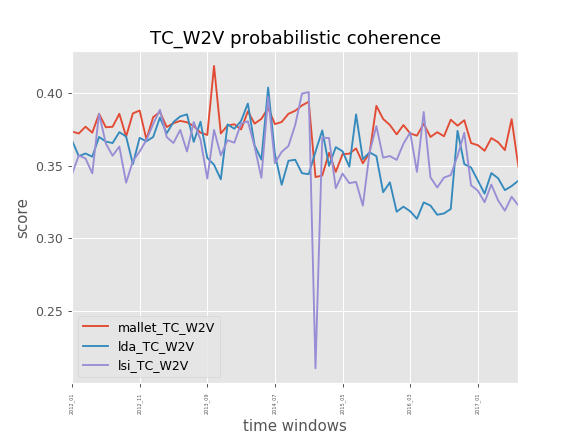

<IPython.core.display.Javascript object>


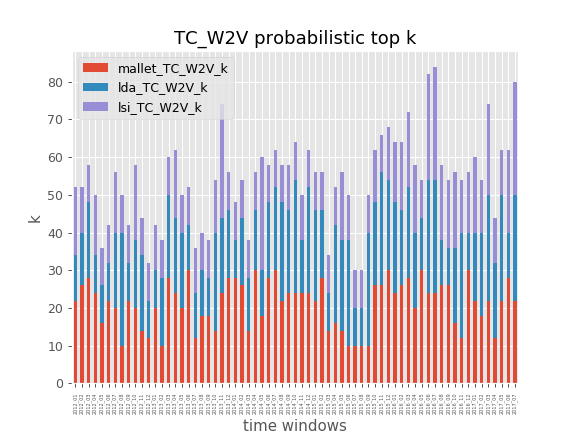

<IPython.core.display.Javascript object>


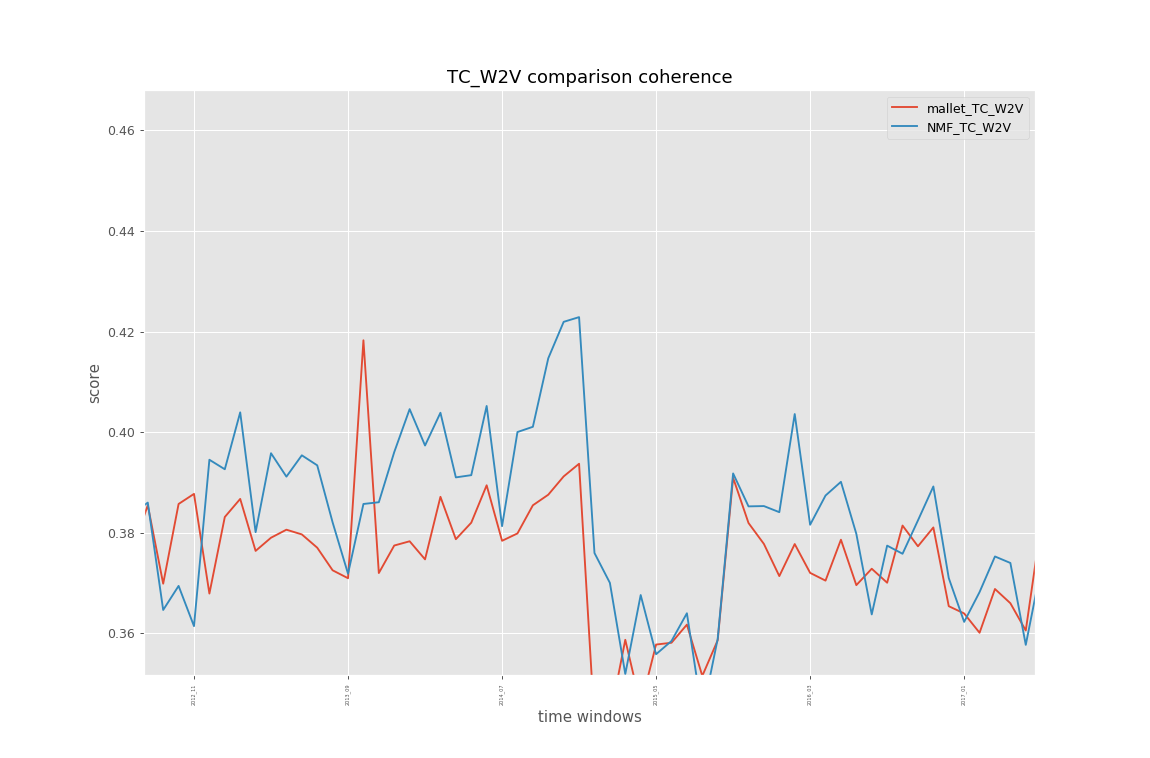

<IPython.core.display.Javascript object>


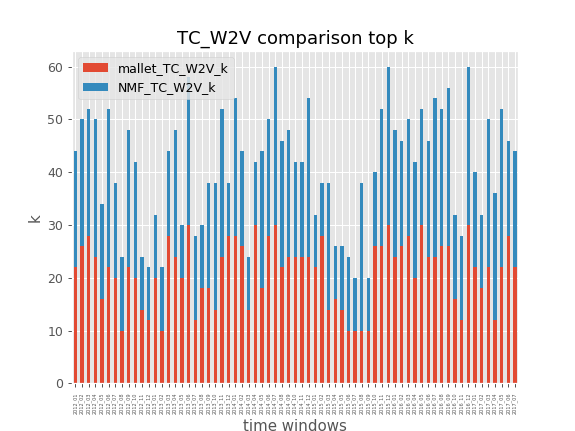

<IPython.core.display.Javascript object>


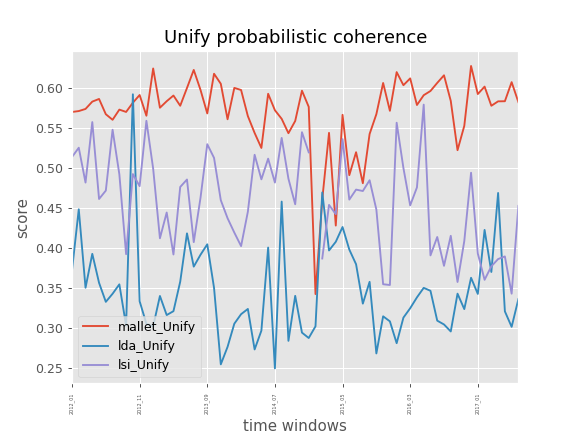

<IPython.core.display.Javascript object>


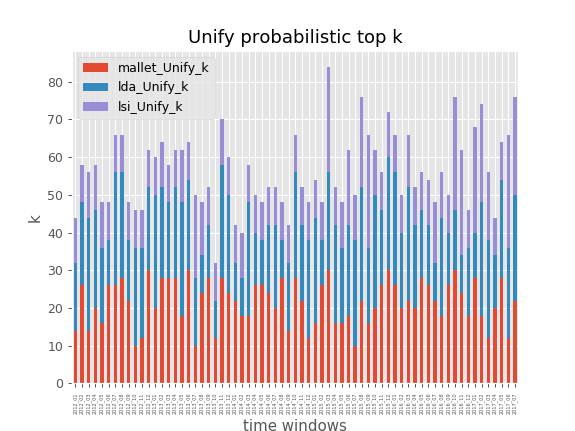

<IPython.core.display.Javascript object>


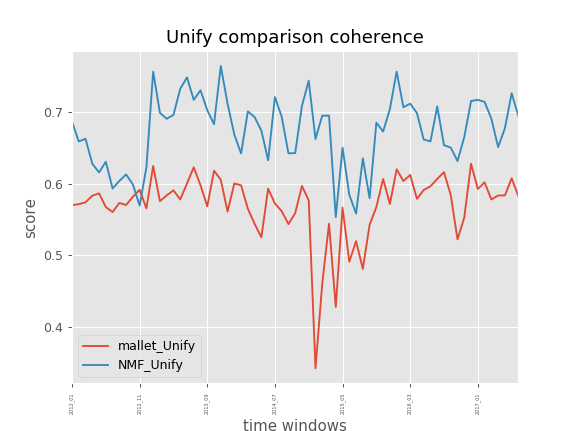

<IPython.core.display.Javascript object>


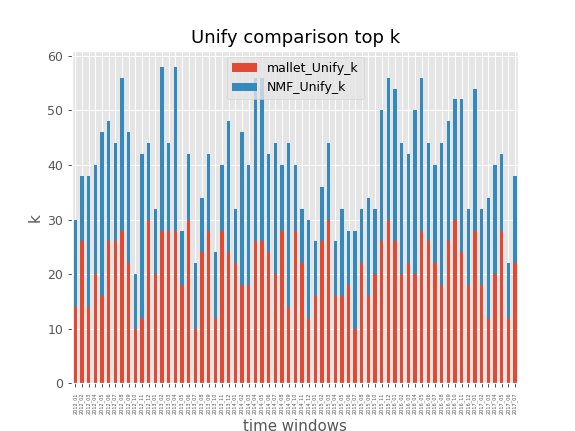

CPU times: user 10.4 s, sys: 1.66 s, total: 12.1 s
Wall time: 10.9 s


In [167]:
%%time


df = pd.read_csv('dynamic_nmf/data/windowbin/csv/windows_coherence_k_performance.csv')
print (df.columns.tolist())
df.set_index(df['window'], inplace=True)
df['NMF_TC_W2V'].fillna(method='bfill', inplace=True)
df['NMF_Unify'].fillna(method='bfill', inplace=True)


df['NMF_TC_W2V'].replace(0, df['NMF_TC_W2V'].mean(), inplace=True)
df['NMF_Unify'].replace(0, df['NMF_Unify'].mean(), inplace=True)

display(df.tail())



print (df.describe())


ax = None
title= 'TC_W2V probabilistic'
graph_coherence_score(df, ['mallet_TC_W2V', 'lda_TC_W2V', 'lsi_TC_W2V'], title)
graph_k(df, ['mallet_TC_W2V_k', 'lda_TC_W2V_k', 'lsi_TC_W2V_k'], title)

title= 'TC_W2V comparison'
graph_coherence_score(df, ['mallet_TC_W2V', 'NMF_TC_W2V'], title)
graph_k(df, ['mallet_TC_W2V_k', 'NMF_TC_W2V_k'], title)

title= 'Unify probabilistic'
graph_coherence_score(df, ['mallet_Unify', 'lda_Unify', 'lsi_Unify'], title)
graph_k(df, ['mallet_Unify_k', 'lda_Unify_k', 'lsi_Unify_k'], title)  

title= 'Unify comparison'
graph_coherence_score(df, ['mallet_Unify',  'NMF_Unify'], title)
graph_k(df, ['mallet_Unify_k', 'NMF_Unify_k'], title) 

In [9]:

def get_nmf_dynamic_topics(k, dictionary, topn=20):
    
    topic_list = []
    topic_df = pd.read_pickle('dynamic_nmf/data/windowbin/result/dynamic.df/dynamic_k%s.pkl' % (k))

    for c in topic_df.ix[:,1:].columns:
        # filter out any token not in 
        if dictionary is not None:
            topic = [x for x in topic_df[c].tolist() if x in dictionary.token2id.keys()]
        else:
            topic = topic_df[c].tolist() 
        topic_list.append(topic[:topn])
        
#     print(topic_list)
    return topic_list

In [85]:
%time


log.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=log.INFO)

actual_kmin=10
actual_kmax=100
df_dynamic = pd.DataFrame(index=list(range(actual_kmin, actual_kmax + 2, 2)))

                          
model_path = 'data/eos/word2vec_model_all.model'
log.info("Loading Word2Vec model from %s ..." % model_path)
model = gensim.models.Word2Vec.load(model_path)

metric = ModelSimilarity(model)
validation_measure = WithinTopicMeasure(metric)


# TC-W2V NMF models 
name = 'NMF_dynamic_tc-w2v'
print (name)    

coherence = []
for k in range(actual_kmin, actual_kmax + 2, 2):
    get_nmf_dynamic_topics(k, None, 20)
    coherence_score = validation_measure.evaluate_rankings(
            get_nmf_dynamic_topics(k, None, 20))

    print("Model coherence dynamic (k=%d) = %.4f" % (k, coherence_score))
    coherence.append(coherence_score)

print(coherence)

df_dynamic['%s_TC_W2V' % name] = coherence

display(df_dynamic)    
df_dynamic.to_csv('dynamic_nmf/data/windowbin/csv/dynamic_coherence_k_performance.csv') 
    
    


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.58 µs
NMF_dynamic_tc-w2v
Model coherence dynamic (k=10) = 0.4356
Model coherence dynamic (k=12) = 0.4188
Model coherence dynamic (k=14) = 0.4212
Model coherence dynamic (k=16) = 0.4112
Model coherence dynamic (k=18) = 0.4116
Model coherence dynamic (k=20) = 0.4124
Model coherence dynamic (k=22) = 0.4111
Model coherence dynamic (k=24) = 0.4075
Model coherence dynamic (k=26) = 0.4048
Model coherence dynamic (k=28) = 0.4063
Model coherence dynamic (k=30) = 0.4078
Model coherence dynamic (k=32) = 0.4071
Model coherence dynamic (k=34) = 0.4111
Model coherence dynamic (k=36) = 0.4118
Model coherence dynamic (k=38) = 0.4119
Model coherence dynamic (k=40) = 0.4121
Model coherence dynamic (k=42) = 0.4127
Model coherence dynamic (k=44) = 0.4116
Model coherence dynamic (k=46) = 0.4085
Model coherence dynamic (k=48) = 0.4077
Model coherence dynamic (k=50) = 0.4119
Model coherence dynamic (k=52) = 0.4073
Model coherence dynamic (k=54) = 0.40

,NMF_dynamic_tc-w2v_TC_W2V
10,0.435583
12,0.418782
14,0.421248
16,0.411221
18,0.411648
20,0.412405
22,0.411058
24,0.407517
26,0.404814
28,0.406280


In [86]:
display(df_dynamic.describe())

,NMF_dynamic_tc-w2v_TC_W2V
count,46.000000
mean,0.406725
std,0.006955
min,0.398895
25%,0.401152
50%,0.405544
75%,0.411190
max,0.435583


In [87]:
%%time

## DO NOT RUN AGAIN 2 days...
dictionary_filepath = 'data/eos/dictionary_EOS_all.dict'
bow_filepath = 'data/eos/corpus_EOS_all.mm'  

corpus = gensim.corpora.MmCorpus(bow_filepath)
print('here')
dictionary = gensim.corpora.Dictionary.load_from_text(dictionary_filepath)  
corpus_text = MyDocuments('dynamic_nmf/data/windowbin/slices/tokenized_window_all.gz') 

coherence = []


name = 'NMF_dynamic_unify'
print ('here')

for k in range(actual_kmin, actual_kmax + 2, 2):
    cm = CoherenceModel(dictionary=dictionary, corpus=corpus, 
                        texts=corpus_text, topics=get_nmf_dynamic_topics(k, dictionary, 20), 
                        coherence='c_v')

    coherence_score = cm.get_coherence()                
    print("Model coherence dynamic (k=%d) = %.4f" % (k, coherence_score))
    coherence.append(coherence_score)

print(coherence)

df_dynamic['%s_TC_W2V' % name] = coherence

display(df_dynamic)    
df_dynamic.to_csv('dynamic_nmf/data/windowbin/csv/dynamic_coherence_k_performance.csv') 



here
here


Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 397, in _send_bytes
    self._send(header)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)


Model coherence dynamic (k=10) = 0.5969
Model coherence dynamic (k=12) = 0.5724
Model coherence dynamic (k=14) = 0.5690
Model coherence dynamic (k=16) = 0.5471
Model coherence dynamic (k=18) = 0.5514
Model coherence dynamic (k=20) = 0.5519
Model coherence dynamic (k=22) = 0.5585
Model coherence dynamic (k=24) = 0.5574
Model coherence dynamic (k=26) = 0.5577
Model coherence dynamic (k=28) = 0.5662
Model coherence dynamic (k=30) = 0.5622
Model coherence dynamic (k=32) = 0.5714
Model coherence dynamic (k=34) = 0.5778
Model coherence dynamic (k=36) = 0.5809
Model coherence dynamic (k=38) = 0.5886
Model coherence dynamic (k=40) = 0.6010
Model coherence dynamic (k=42) = 0.6084
Model coherence dynamic (k=44) = 0.6066
Model coherence dynamic (k=46) = 0.5931
Model coherence dynamic (k=48) = 0.5866
Model coherence dynamic (k=50) = 0.6024
Model coherence dynamic (k=52) = 0.5971
Model coherence dynamic (k=54) = 0.5879
Model coherence dynamic (k=56) = 0.5952
Model coherence dynamic (k=58) = 0.5838


,NMF_dynamic_tc-w2v_TC_W2V,NMF_dynamic_unify_TC_W2V
10,0.435583,0.596857
12,0.418782,0.572438
14,0.421248,0.568953
16,0.411221,0.547078
18,0.411648,0.551371
20,0.412405,0.551863
22,0.411058,0.558455
24,0.407517,0.557438
26,0.404814,0.557674
28,0.406280,0.566201


CPU times: user 2h 53min 14s, sys: 1min 46s, total: 2h 55min
Wall time: 2d 12h 24min 5s


Dynamic tc-w2v
    NMF dynamic TC-W2V  NMF dynamic unify
k                                        
10            0.435583           0.596857
14            0.421248           0.568953
12            0.418782           0.572438
42            0.412661           0.608368
20            0.412405           0.551863
Dynamic unify
[['can', 'will', 'one', 'year', 'go', 'like', 'get', 'make', 'people', 'say', 'time', 'good', 'world', 'know', 'see', 'just', 'now', 'work', 'think', 'many'], ['shelling', 'damascus', 'suburbs', 'regime', 'homs', 'neighborhood', 'idlib', 'forces', 'daraa', 'report', 'fierce', 'hama', 'town', 'fsa', 'city', 'martyrs', 'artillery', 'al', 'mortar', 'army'], ['syrian', 'syria', 'assad', 'opposition', 'talk', 'geneva', 'say', 'foreign', 'arab', 'peace', 'al_assad', 'regime', 'damascus', 'government', 'president_bashar', 'meeting', 'political', 'conference', 'support', 'terrorism'], ['israel', 'israeli', 'palestinian', 'jerusalem', 'palestinians', 'hamas', 'gaza', 'netanyahu

<IPython.core.display.Javascript object>


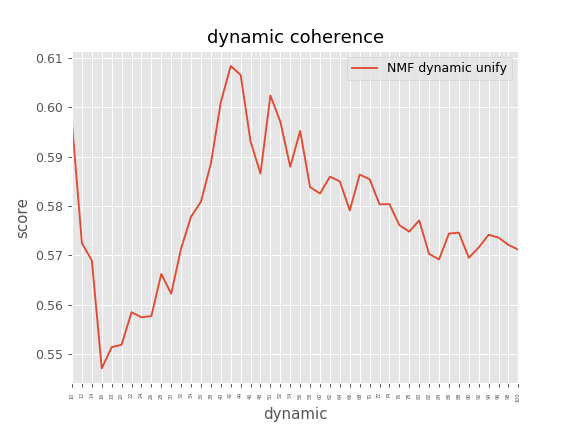

,NMF dynamic TC-W2V,NMF dynamic unify
k,,
10,0.435583,0.596857
12,0.418782,0.572438
14,0.421248,0.568953
16,0.411221,0.547078
18,0.411648,0.551371


In [169]:
# Graph

df_dynamic = pd.read_csv('dynamic_nmf/data/windowbin/csv/dynamic_coherence_k_performance.csv') 



# df_dynamic.describe()
df_dynamic.columns = ['k', 'NMF dynamic TC-W2V', 'NMF dynamic unify']
df_dynamic.set_index('k', inplace=True)

print('Dynamic tc-w2v')
# print(get_nmf_dynamic_topics(10, None, 20))
print(df_dynamic.sort_values(by=['NMF dynamic TC-W2V'],  ascending=False).head())

print('Dynamic unify')
print(get_nmf_dynamic_topics(42, None, 20))  
print(df_dynamic.sort_values(by=['NMF dynamic unify'],  ascending=False).head())
    
ax = df_dynamic[['NMF dynamic unify']].plot(xticks=df_dynamic.index)
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('dynamic')

plt.ylabel('score')
plt.title('dynamic coherence')
plt.legend(loc='best')
plt.show()
plt.savefig('data/eos/graphs/dynamic_coherence_plot.png', dpi=800)   

df_dynamic.head()
# df_dynamic.describe()

In [191]:


# Get the top 5 topic words in one window from LDA Mallet and NMF for comparison
nmf_model = 'dynamic_nmf/data/windowbin/result/tf_idf_tokenized_window_2016*.pkl'

mallet = 'data/eos/mallet/Malletmodel_%s_K_%s.pkl'
windows = ['2016_01', '2016_02', '2016_03', '2016_04','2016_05','2016_06'
#            '2016_07', '2016_09','2016_10','2016_11','2016_12'
          ]


df = pd.read_csv('dynamic_nmf/data/windowbin/csv/windows_coherence_k_performance.csv')
df.set_index(df['window'], inplace=True)

df = df[df['window'].isin(windows)]
df.head()


for index, row in df.iterrows():
    print(index, 'NMF', row['NMF_TC_W2V_k'])
    print(get_nmf_topics(row['window'], row['NMF_TC_W2V_k'], None, 5))
    ldamodel = joblib.load(mallet % (row['window'], row['mallet_TC_W2V_k']))
    print(index, 'Mallet', row['mallet_TC_W2V_k'])
    print(get_topics(ldamodel, row['mallet_TC_W2V_k'], 5))
    

# ldamodel = joblib.load(fname)
# topic_num = 
# print(get_topics(ldamodel, topic_num, 5))



2016_01 NMF 24
[['photo', 'photos', 'istanbul', 'turkey', 'turkish'], ['child', 'humanitarian', 'un', 'aid', 'people'], ['window_click', 'share', 'new', 'opens', 'iraqinews'], ['inmate', 'jail', 'hallock', 'escape', 'orange_county'], ['talk', 'opposition', 'syrian', 'geneva', 'peace'], ['iran', 'rouhani', 'sanction', 'iranian', 'nuclear'], ['alert', 'click_here', 'disable', 'remove', 'add'], ['refugee', 'merkel', 'germany', 'border', 'migrant'], ['match', 'murray', 'australian', 'win', 'round'], ['russian', 'airspace', 'russia', 'turkey', 'turkish'], ['iran', 'saudi_arabia', 'saudi', 'shi', 'riyadh'], ['oil', 'opec', 'price', 'market', 'production'], ['iraq', 'islamic_state', 'strike', 'iraqi', 'coalition'], ['monastery', 'elijah', 'st', 'mosul', 'church'], ['video', 'paris', 'attacks', 'islamic_state', 'jihadi'], ['egypt', 'suspect', 'bomb', 'airport', 'source'], ['china', 'xi', 'chinese', 'egypt', 'president_xi'], ['migrant', 'greece', 'boat', 'turkey', 'europe'], ['turkey', 'kurdish

In [71]:
%%time


from gensim import corpora
corpus_text = MyDocuments('dynamic_nmf/data/windowbin/slices/tokenized_window_all.gz') 

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(corpus_text)
dictionary.save_as_text('data/eos/dictionary_EOS_all.dict')



CPU times: user 5min 29s, sys: 7.97 s, total: 5min 37s
Wall time: 5min 37s


In [72]:
%%time


# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in corpus_text]
corpora.MmCorpus.serialize('data/eos/corpus_EOS_all.mm', corpus)

CPU times: user 7min 54s, sys: 8.06 s, total: 8min 2s
Wall time: 8min 4s


In [13]:
# print(get_nmf_dynamic_topics(42, None, 20))  
df = pd.DataFrame(get_nmf_dynamic_topics(42, None, 20))
df.to_csv('experiment/dynamic_nmf_42.csv')